In [18]:
import pandas as pd
import os
import numpy as np

pasta_arquivos = "dados_acoes"

precos_dict = {}
contagem_novas = 0
empresas_novas = []

# Data de Início do Projeto (Como você definiu)
data_inicio_projeto = pd.Timestamp("2015-01-01")

print("--- Carregando Dados ---")

# Varre todos os arquivos
arquivos = [f for f in os.listdir(pasta_arquivos) if f.endswith('.csv')]

for arquivo in arquivos:
    ticker = arquivo.replace(".csv", "")
    
    # Lê o arquivo
    caminho_completo = os.path.join(pasta_arquivos, arquivo)
    df_temp = pd.read_csv(caminho_completo)
    
    # Arruma data e índice
    df_temp['Date'] = pd.to_datetime(df_temp['Date'])
    df_temp = df_temp.set_index('Date')
    
    # Apenas guardamos o preço. O Pandas vai preencher o resto com NaN (Vazio).
    
    precos_dict[ticker] = df_temp['Adj Close']

# Consolida a Matriz
df_matriz = pd.DataFrame(precos_dict)
    
# Conta novas empresas
datas_inicio = df_matriz.apply(lambda col: col.first_valid_index())
# A data mais comum (moda) é considerada o "início do projeto"
data_padrao = datas_inicio.mode()[0]
print(f"Data padrão detectada (maioria das empresas): {data_padrao.strftime('%Y-%m-%d')}")

# Quem começou depois dessa data é "nova"
empresas_novas = datas_inicio[datas_inicio > data_padrao]
print(f"\nRelatório de empresas novas ({len(empresas_novas)} encontradas):")
# Ordena por data de estreia
empresas_novas_sorted = empresas_novas.sort_values()
for ticker, data in empresas_novas_sorted.items():
    print(f"   -> {ticker} (Estreou em: {data.strftime('%Y-%m-%d')})")

print("\n--- Caçando Gêmeas (Correlação > 99%) ---")
# Cálculo da Correlação para achar duplicatas
# Usamos apenas dados recentes para garantir que todas tenham preços na comparação
df_check = df_matriz.dropna() 
correlacao = df_check.corr().abs()

# Pega o triângulo de cima da matriz (pra não conferir A com B e B com A)
upper = correlacao.where(np.triu(np.ones(correlacao.shape), k=1).astype(bool))

to_drop = [] 
LIMITE_CORRELACAO = 0.99
# Acha colunas com correlação > 0.99
for coluna in upper.columns:
    # Se essa coluna tiver correlação alta com ALGUÉM
    if any(upper[coluna] > LIMITE_CORRELACAO):
        # Descobre quem é a "irmã" dela
        irma = upper[coluna][upper[coluna] > LIMITE_CORRELACAO].index[0]
        score = upper[coluna][upper[coluna] > LIMITE_CORRELACAO].values[0]

        print(f"DUPLICATA DETECTADA:")
        print(f"Entre: {irma} e {coluna} (Correlação: {score:.4f})")
        print(f"Decisão: Removendo '{coluna}' e mantendo '{irma}'.")
        to_drop.append(coluna)

# Limpeza
df_final = df_matriz.drop(columns=to_drop)

# Salvar
arquivo_saida = "matriz_final_v3_survivorship.csv"
df_final.to_csv(arquivo_saida)

print("-" * 40)
print(f"PROCESSO AUTOMÁTICO CONCLUÍDO!")
print(f"Ativos Removidos: {len(to_drop)}")
print(f"Ativos Restantes: {df_final.shape[1]}")
print(f"Salvo em: '{arquivo_saida}'")

--- Carregando Dados ---
Data padrão detectada (maioria das empresas): 2015-01-02

Relatório de empresas novas (3 encontradas):
   -> PYPL (Estreou em: 2015-07-06)
   -> UBER (Estreou em: 2019-05-10)
   -> PLTR (Estreou em: 2020-09-30)

--- Caçando Gêmeas (Correlação > 99%) ---
DUPLICATA DETECTADA:
Entre: GOOG e GOOGL (Correlação: 0.9998)
Decisão: Removendo 'GOOGL' e mantendo 'GOOG'.
----------------------------------------
PROCESSO AUTOMÁTICO CONCLUÍDO!
Ativos Removidos: 1
Ativos Restantes: 100
Salvo em: 'matriz_final_v3_survivorship.csv'


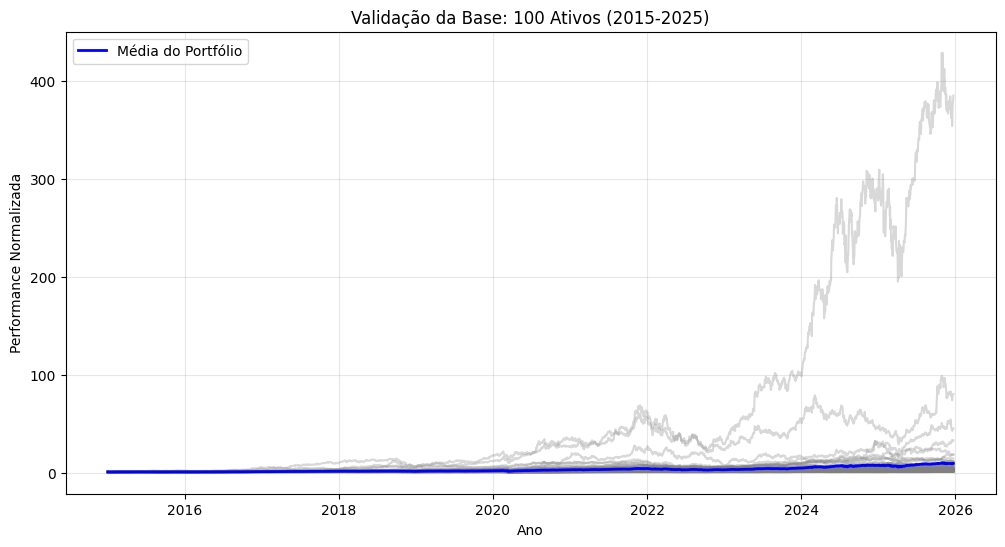

O outlier é: NVDA
Ela multiplicou o capital por 384.84 vezes.


In [19]:
# Validação visual dos dados

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("matriz_final_v3_survivorship.csv", index_col="Date", parse_dates=True)

# Normaliza para tudo começar em 1 (para o gráfico ficar comparável)
# É possível ver se tem algum dado bizarro ou algum buraco
df_norm = df / df.iloc[0]

plt.figure(figsize=(12, 6))
plt.plot(df_norm, alpha=0.3, color='gray') # Todas as ações em cinza
plt.plot(df_norm.mean(axis=1), color='blue', linewidth=2, label='Média do Portfólio') # A média em destaque
plt.title(f"Validação da Base: {len(df.columns)} Ativos (2015-2025)")
plt.xlabel("Ano")
plt.ylabel("Performance Normalizada")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("validacao_dados.png") # Salva pra você mandar
plt.show()

# Pega o valor acumulado no último dia
retorno_total = df_norm.iloc[-1]

# Descobre quem é o máximo
nome_max = retorno_total.idxmax()
quanto_cresceu = retorno_total.max()

print(f"O outlier é: {nome_max}")
print(f"Ela multiplicou o capital por {quanto_cresceu:.2f} vezes.")